# Eindopdracht test model 1.2

normalizeer de doelvariabele
kijk naar de metrics


## Inladen Bibliotheek en data 

In [33]:
import torch
from torch import nn, Tensor
import torch.nn.functional 
from torchvision.transforms import functional as F

from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset, Subset
from pipetorch.data import read_from_kaggle, plot_boundaries
from pipetorch.train import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import os
from pathlib import Path  # Import Path from pathlib
from PIL import Image
from sklearn.metrics import r2_score
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import re

from optuna.visualization.matplotlib import plot_slice, plot_contour
from optuna import create_study, TrialPruned
import cv2





In [34]:
folder = '/datb/BotsNLE/angle90'
folder_path = folder
expanded_folder_path = os.path.expanduser(folder_path)

if os.path.exists(expanded_folder_path):
    print(f"The folder '{expanded_folder_path}' exists.")
else:
    print(f"The folder '{expanded_folder_path}' does not exist.")

The folder '/datb/BotsNLE/angle90' exists.


In [35]:
!ls $folder | head

0000-0.02--0.5625.jpg
0001-0.33--1.6875.jpg
0002-0.62--1.125.jpg
0003-0.91--4.21875.jpg
0004-1.21-3.375.jpg
0005-1.50--3.9374999999999996.jpg
0006-1.81--4.21875.jpg
0007-2.13--1.125.jpg
0008-2.43-2.25.jpg
0009-2.73--3.0937500000000004.jpg
ls: write error: Broken pipe


## Data extraction

In [36]:
def extract_labels(input_path):
    # Extract the filename from the path
    filename = Path(input_path).stem  # Get the filename without the extension
    parts = re.split(r'-(?![^-]-)', filename, maxsplit=2) # Split on '-'
    # print(parts)#

    
    if len(parts) >= 3 and parts[-1]:  # Ensure we have enough parts
        y = float(parts[-1])  # Last part is y2, ensure positive
        # normalise y between 1 and -1
        y = y / 90
        return y # Return as a list of two labels
    else:
        print(f"Skipping file (not enough parts to extract labels): {filename}")


In [37]:
# voor het inladen van de afbeedingen in het juiste format
class FileDataset(Dataset):
    def __init__(self, folder, image_size, extension='jpg'):
        super().__init__()
        self.files = list(Path(folder).expanduser().glob(f'*.{extension}'))

        # Transformations to apply to the images
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

        # Lijsten voor afbeeldingen en labels
        self.images = []
        self.labels = []

        # Laad afbeeldingen en labels
        self._load_images_and_labels()
        
        
    def _load_images_and_labels(self):
        for img_path in self.files:
            # Laad de afbeelding
            img = Image.open(img_path).convert('L')  # Open image and convert to grayscale
            
            # Extract the corresponding label for the image using the filename
            y = extract_labels(img_path)
            label = torch.tensor(y, dtype=torch.float32).view(1)  # Ensure label shape is [1]

            if label is None:
                raise ValueError(f"No label found for image: {img_path.name}")
            
            # Apply the transformation (resize, to tensor)
            img = self.transform(img)
            img = img / 255.0
            # Voeg de originele afbeelding toe
            self.images.append(img)
            self.labels.append(label)
            
            # Maak de flipped afbeelding en voeg deze ook toe
            flipped_img = F.hflip(img)  # Flip image horizontally
            
            # Voeg de flipped afbeelding toe aan de lijst
            self.images.append(flipped_img)
            # Voeg het omgekeerde label toe (negatief label)
            self.labels.append(-label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        # Haal de afbeelding en het bijbehorende label op
        img = self.images[i]
        label = self.labels[i]

        return img, label


In [38]:
# Create the dataset with label data (without the 'extension' argument issue)
image_size = 32
batch_size = 32
ds = FileDataset(folder, image_size, extension='jpg')
len(ds)

1624

In [39]:
dataset_size = len(ds)
train_size = int(0.80 * dataset_size)
valid_size = dataset_size - train_size


train_ds, valid_ds = random_split(ds, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=batch_size,
                            shuffle=True, num_workers=2)

valid_dl = DataLoader(valid_ds, batch_size=batch_size,
                            shuffle=True, num_workers=2)


In [40]:
ds1 = train_dl.dataset
X, y = ds1[0]
X.shape, y.shape, y, ds1[0]



(torch.Size([1, 32, 32]),
 torch.Size([1]),
 tensor([-0.0094]),
 (tensor([[[0.0028, 0.0030, 0.0030,  ..., 0.0023, 0.0023, 0.0023],
           [0.0029, 0.0030, 0.0031,  ..., 0.0023, 0.0023, 0.0023],
           [0.0029, 0.0030, 0.0031,  ..., 0.0024, 0.0023, 0.0023],
           ...,
           [0.0028, 0.0029, 0.0030,  ..., 0.0032, 0.0031, 0.0030],
           [0.0028, 0.0029, 0.0030,  ..., 0.0031, 0.0031, 0.0030],
           [0.0027, 0.0028, 0.0029,  ..., 0.0031, 0.0031, 0.0030]]]),
  tensor([-0.0094])))

In [41]:
def showx(x):
    plt.imshow(np.transpose(x,(1,2,0)))
    
def demo_batch():
    real_batch = next(iter(train_dl))
    images, labels = real_batch
    height = images.shape[2]
    remove_upper_half = transforms.Lambda(lambda images: images[:, :, height//2 :, :])  # Removes upper half, hogere waarden voor x in [:,:,x:,:] betekend een grter deel wat van boven gekropt wordt bij 19 is er nog wel wat ruis in het model maar duidelijk alleen de lijn in beeld
    images = remove_upper_half(images)

    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.title("Training Images")
    showx(vutils.make_grid(images[:24], padding=2, normalize=True))

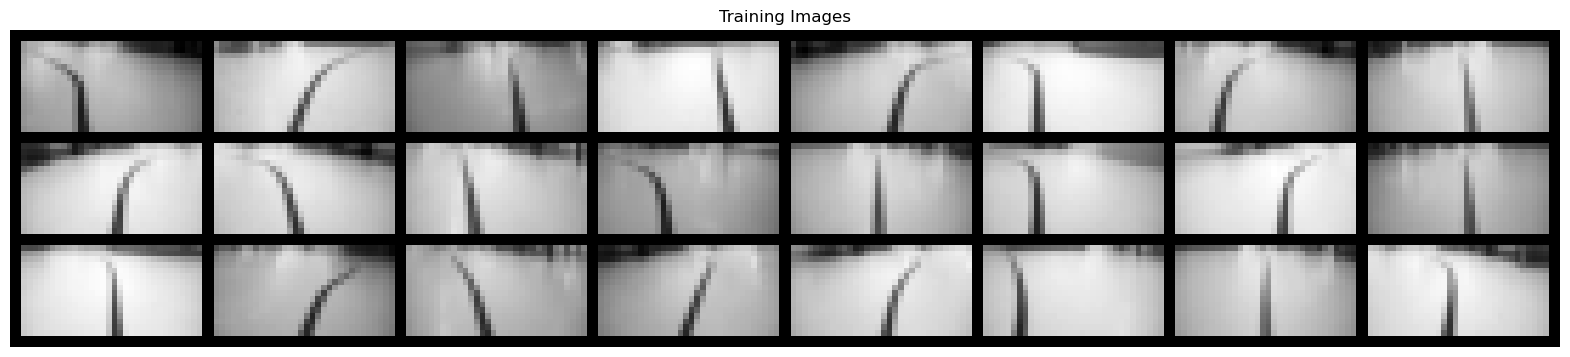

In [42]:
demo_batch()

In [43]:
def Pixel_Mean_Std(data):   
    """
    Calculate the mean and standard deviation for normalization.
    
    Args:
        data (Dataset): The dataset to calculate mean and std for.
        
    Returns:
        tuple: Mean and standard deviation tensors.
    """
    # Create a DataLoader for the dataset with a large batch size to process all data at once
    data_loader = DataLoader(data, batch_size=len(data), shuffle=False)
    
    # Initialize variables to accumulate mean and std
    mean = 0.0
    std = 0.0
    total_samples = 0

    # Iterate through the dataset
    for inputs, _ in data_loader:  # Unpack into inputs (images) and labels (ignored here)
        batch_size = inputs.size(0)
        # Flatten the image dimensions for mean and std calculation
        inputs = inputs.view(batch_size, inputs.size(1), -1)  # Shape: (batch_size, channels, height*width)
        mean += inputs.mean(2).sum(0)  # Mean across spatial dimensions, summed over the batch
        std += inputs.std(2).sum(0)   # Std across spatial dimensions, summed over the batch
        total_samples += batch_size

    # Calculate mean and std across the entire dataset
    mean /= total_samples
    std /= total_samples

    print("Mean:", mean)
    print("Std:", std)
    return mean, std

# Call the function with your dataset
mean, std = Pixel_Mean_Std(ds)


Mean: tensor([0.0022])
Std: tensor([0.0008])


## Baseline Model bouwen

In [44]:
# Data augmentatie
def trans(mean, std):
    return transforms.Normalize(mean, std)

class RemoveUpperHalf(nn.Module):
    def forward(self, img):
        # Remove the upper half of the image (assuming channel-first format)
        height = img.shape[2]
        im = img[:, :, height//2 :, :]
        return im
    
def augment():
        return nn.Sequential(
                RemoveUpperHalf(),  # Remove upper half
                transforms.Resize((32, 32), antialias=True),  # Resize to maintain dimensions
                )

def convolutional_layer_image():
    return   nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    ) 

def conv_layer():
    return nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
        nn.Flatten(1),
        nn.Linear(32 * 32 * 16, 1)  # Adjust dimensions if needed
    )


In [45]:
class Model(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        
        # normalisation
        self.normalize = trans(mean, std)
        
        # augmentation
        self.augment = augment()
        
        # Convolutional layers
        self.conv = conv_layer()
        
        # voor afbeeldingen maken
        self.convolution_image = convolutional_layer_image()
        
        
    def forward(self, X):
      #  X = self.normalize(X)
        if self.training:
            X = self.augment(X)
        X = self.conv[:-2](X)  # Exclude Flatten and Linear for now
     #   print("Shape after convolutions:", X.shape)
        X = self.conv[-2:](X)  # Apply Flatten and Linear
        return X


In [46]:
def augmentation_visualisation_with_conv(Model):
    """
    Visualizes the original, augmented, and convolutional results of an image.
    
    Parameters:
        model: The model containing the augmentation and convolution logic.
        sample_image: A single input image tensor.
    """

    # Instantiate and evaluate the model
    model = Model
    model.eval()  # Ensure the model is in evaluation mode

    # Load a single example from your dataset
    sample_image, _ = next(iter(train_dl))  # Assuming train_dl is your DataLoader
    sample_image = sample_image[:1]  # Take a single image (batch size = 1)

    # Normalize and augment the input
    normalized_image = model.normalize(sample_image)
    print(f'normalized image shape{normalized_image.shape}')
   
    
    augmented_image = model.augment(normalized_image)
    print(f'Augmented image shape{augmented_image.shape}')

    # Extract convolutional features
    conv_output = model.convolution_image(augmented_image)
    print(f'conv_output shape{conv_output.shape}')

    # Convert tensors to numpy for visualization
    # Original image
    normal_image = sample_image[0].squeeze().detach().cpu().numpy()

    # Augmented image
    augmented_image_squeezed = augmented_image[0].squeeze().detach().cpu().numpy()

    # Convolutional output (take the first channel)
    conv_output_channel = conv_output[0, 0].detach().cpu().numpy()


    # Plot all three images side by side
    fig, axes = plt.subplots(1, 3)
    
    # Original image
    axes[0].imshow(normal_image, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Augmented image
    axes[1].imshow(augmented_image_squeezed, cmap="gray")
    axes[1].set_title("Augmented Image")
    axes[1].axis("off")

    # Convolutional output
    axes[2].imshow(conv_output_channel, cmap="gray")
    axes[2].set_title("Convolutional Output")
    axes[2].axis("off")

    # Display the plot
    plt.tight_layout()
    plt.show()

normalized image shapetorch.Size([1, 1, 32, 32])
Augmented image shapetorch.Size([1, 1, 32, 32])
conv_output shapetorch.Size([1, 32, 31, 31])


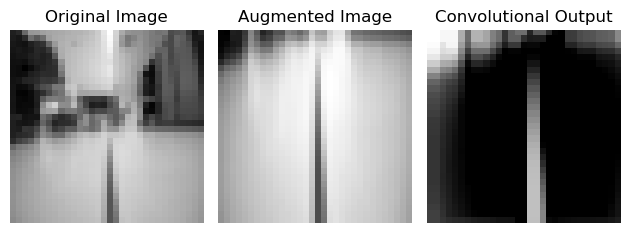

In [47]:
augmentation_visualisation_with_conv(Model(mean, std))

In [48]:
model = Model(mean, std)
model.cuda()

Model(
  (normalize): Normalize(mean=tensor([0.0022]), std=tensor([0.0008]))
  (augment): Sequential(
    (0): RemoveUpperHalf()
    (1): Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
  )
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=16384, out_features=1, bias=True)
  )
  (convolution_image): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
)

In [61]:
t = Trainer(model, 
            loss=nn.RMSELoss(), 
            train_dl=train_dl, 
            valid_dl=valid_dl, 
            metrics=R2Score,
            halt_notebook=False) 

AttributeError: module 'torch.nn' has no attribute 'RMSELoss'

  0%|          | 0/40 [00:00<?, ?it/s]

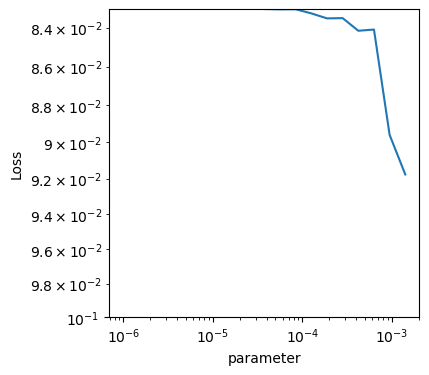

In [50]:
t.lr_find()

In [51]:
t.train(10, lr=(1e-4, 1e-3))

Total:   0%|          | 0/16640 [00:00<?, ?it/s]

Working on cuda:3
 1 1.56s trainloss=0.08192 validloss=0.09139 R2Score=-0.10190 
 2 0.42s trainloss=0.07258 validloss=0.08437 R2Score=-0.01730 
 3 0.48s trainloss=0.07269 validloss=0.08315 R2Score=-0.00259 
 4 0.44s trainloss=0.07197 validloss=0.08436 R2Score=-0.01722 
 5 0.44s trainloss=0.07201 validloss=0.08546 R2Score=-0.03046 
 6 0.44s trainloss=0.07268 validloss=0.08377 R2Score=-0.01007 
 7 0.43s trainloss=0.07283 validloss=0.08361 R2Score=-0.00815 
 8 0.43s trainloss=0.07234 validloss=0.08349 R2Score=-0.00670 
 9 0.43s trainloss=0.07244 validloss=0.08374 R2Score=-0.00964 
10 0.42s trainloss=0.07322 validloss=0.08299 R2Score=-0.00067 


In [62]:
def trial(trial):
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    model = Model(mean, std)
    t = Trainer(model, 
                loss=nn.MAELoss(), 
                train_dl=train_dl, 
                valid_dl=valid_dl,
                #metrics=nn.MSELoss(),
                metrics=R2Score,
                halt_notebook=False,
                silent=True) 
    t.train(20, lr=(lr/10, lr), cycle=10)        
    r2 = t.optimum(R2Score)
    #mse = t.optimum(nn.MSELoss())  
    if r2[0] < 0.1:
        raise TrialPruned('r2 too low')
    return r2

study = create_study(direction='maximize')
study.optimize(trial, n_trials=20)
    

[I 2025-01-08 14:17:06,111] A new study created in memory with name: no-name-1fb597b0-1af7-4847-b214-8800eb929433
[W 2025-01-08 14:17:06,120] Trial 0 failed with parameters: {'lr': 0.023377003808837} because of the following error: AttributeError("module 'torch.nn' has no attribute 'MAELoss'").
Traceback (most recent call last):
  File "/opt/jupyterhub/anaconda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_619026/4268525655.py", line 5, in trial
    loss=nn.MAELoss(),
AttributeError: module 'torch.nn' has no attribute 'MAELoss'. Did you mean: 'MSELoss'?
[W 2025-01-08 14:17:06,125] Trial 0 failed with value None.


AttributeError: module 'torch.nn' has no attribute 'MAELoss'

/tmp/ipykernel_619026/1025440081.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study, target_name='r2')


<Axes: title={'center': 'Slice Plot'}, xlabel='lr', ylabel='r2'>

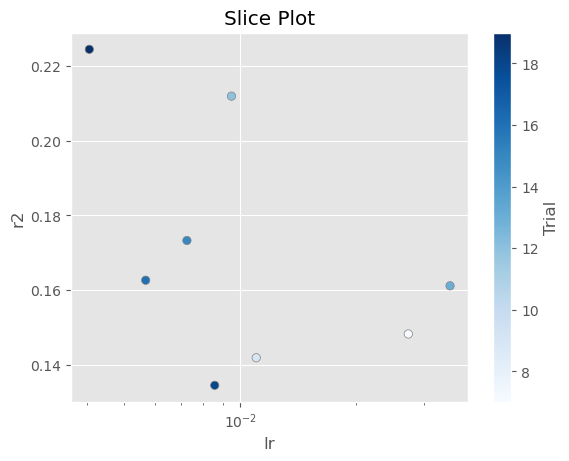

In [57]:
plot_slice(study, target_name='r2')

/tmp/ipykernel_619026/927314822.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2025-01-08 14:08:39,153] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: >

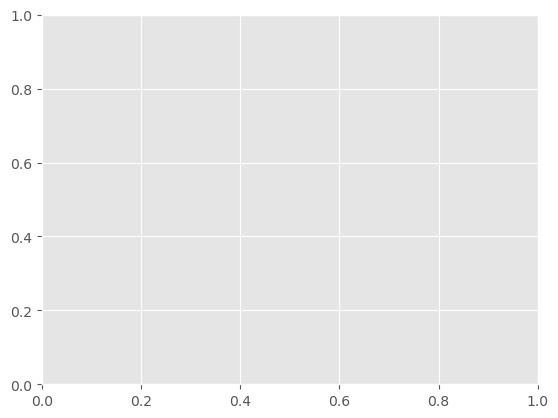

In [58]:
plot_contour(study)

## Augmentatie bepalen

In [59]:
# Data augmentatie
def trans(mean, std):
    return transforms.Normalize(mean, std)

class RemoveUpperHalf(nn.Module):
    def forward(self, img):
        # Remove the upper half of the image (assuming channel-first format)
        return img[:, :, 20:, :]
    

class ThresholdBinary(nn.Module):
    def forward(self, img):
        img_np = img.squeeze().cpu().numpy()
        _, img_thresh = cv2.threshold(img_np, -1.1, 0.5, cv2.THRESH_BINARY_INV)
        img_tensor = torch.tensor(img_thresh).unsqueeze(0).unsqueeze(0).to(img.device)  # Voeg kanaaldimensie toe
        return img_tensor


def augment():
    augment = nn.Sequential(
        RemoveUpperHalf(),  # Remove upper half
        ThresholdBinary(),  # Apply binary thresholding
        transforms.Resize((32, 32), antialias=True),  # Resize to maintain dimensions
    )
    return augment
    

def convolutional_layer_image():
    conv = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,4), stride=(3,2))
    )
    return conv

#def conv_layer():
#    conv = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#        nn.ReLU(),
#        nn.MaxPool2d(kernel_size=2, stride=1),
#        nn.Flatten(1),
#        nn.Linear(32 * 16 * 8, 1)  # Adjust dimensions if needed
#    )
#    return conv

def conv_layer():
    conv = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 4), stride=(3, 2)),
        nn.Flatten(1),
        nn.Linear(32 * 32 * 16, 1)  # Adjust dimensions if needed
    )
    return conv

-----------------volgende set-----------------
normalized image shapetorch.Size([1, 1, 32, 32])
Augmented image shapetorch.Size([1, 1, 32, 32])
conv_output shapetorch.Size([1, 32, 11, 15])


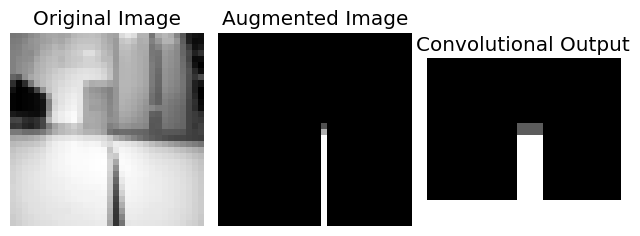

-----------------volgende set-----------------
normalized image shapetorch.Size([1, 1, 32, 32])
Augmented image shapetorch.Size([1, 1, 32, 32])
conv_output shapetorch.Size([1, 32, 11, 15])


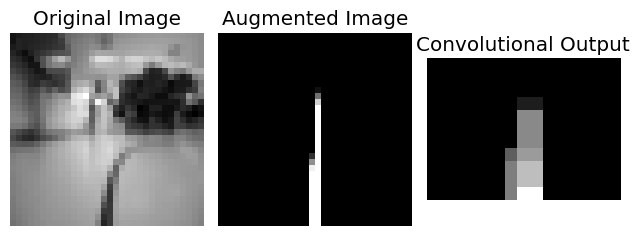

-----------------volgende set-----------------
normalized image shapetorch.Size([1, 1, 32, 32])
Augmented image shapetorch.Size([1, 1, 32, 32])
conv_output shapetorch.Size([1, 32, 11, 15])


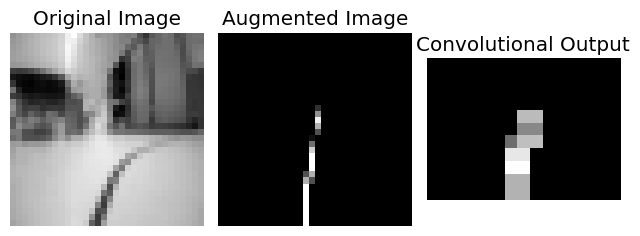

-----------------volgende set-----------------
normalized image shapetorch.Size([1, 1, 32, 32])
Augmented image shapetorch.Size([1, 1, 32, 32])
conv_output shapetorch.Size([1, 32, 11, 15])


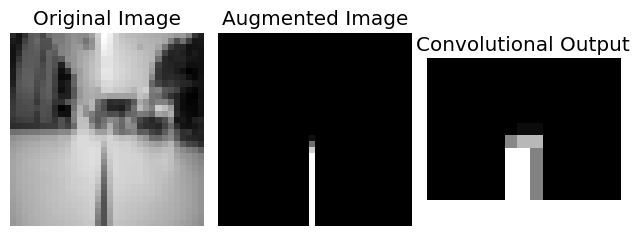

In [60]:
for i in range(4):
    print("-----------------volgende set-----------------")
    augmentation_visualisation_with_conv(Model(mean, std))


  0%|          | 0/40 [00:00<?, ?it/s]

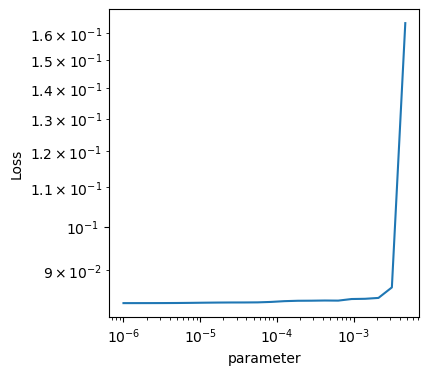

In [55]:
t.lr_find()

In [56]:
t.train(10, lr=(1e-4, 1e-1))

Total:   0%|          | 0/16640 [00:00<?, ?it/s]

Working on cuda:3
11 0.42s trainloss=3.99010 validloss=1.50966 R2Score=-17.20287 
12 0.45s trainloss=0.40115 validloss=0.22774 R2Score=-1.74599 
13 0.46s trainloss=0.11356 validloss=0.08720 R2Score=-0.05136 
14 0.46s trainloss=0.07620 validloss=0.08289 R2Score=0.00049 
15 0.49s trainloss=0.07399 validloss=0.08986 R2Score=-0.08354 
16 0.46s trainloss=0.07241 validloss=0.08299 R2Score=-0.00064 
17 0.49s trainloss=0.07328 validloss=0.08385 R2Score=-0.01106 
18 0.46s trainloss=0.07419 validloss=0.08688 R2Score=-0.04751 
19 0.47s trainloss=0.07329 validloss=0.08284 R2Score=0.00119 
20 0.47s trainloss=0.07257 validloss=0.08534 R2Score=-0.02896 
